# 光伏Performance ratio(Pr)值年衰减分析

熟悉光伏的朋友应该都知道，一个光伏电站组件的Pr值测算，对于估算项目的成本，组件的采购及未来的投资回收期都有重要的意义。
但是大部分时间，除了一开始组件供应商提供的Pr保证外，很多项目运营人员很难通过大量的现场光伏监测数据获得组件实际的Pr衰减情况。

为此，我参考了rdtools模块的介绍案例，基于光伏电站的发电量数据对光伏电站的pr衰减值进行了分析

Pr值的测算主要分成了以下几个步骤：<br>
     1.初始计算<br>
     2.数据标准化<br>
     3.数据过滤<br>
     4.数据聚合<br>
     5.Pr计算<br>

本次分析数据源来自the Desert Knowledge Australia Solar Centre的Site 12光伏电站文件，有兴趣的朋友可以在以下链接中下载

http://dkasolarcentre.com.au/historical-data/download

In [1]:
'''
评价光伏电站Pr衰减的包
这个包的安装挺坑的，直接pip找不到
没办法只能在Github上下载tar.gz文件
然后管理员模式打开anaconda prompt，之后cd到文件路径
用下面命令安装
pip install --user rdtools-1.2.0.tar.gz
注意一定要加--user否则会被denied
'''
import rdtools

D:\Program\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import datetime
from collections import Counter
from collections import OrderedDict
from datetime import timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pvlib
%matplotlib inline
#使用%matplotlib命令可以将matplotlib的图表直接嵌入到Notebook之中，或者使用指定的界面库显示图表，它有一个参数指定matplotlib图表的显示方式。inline表示将图表嵌入到Notebook中。

#导入可以将数据转化为时间的模块
from pandas.tseries import converter
converter.register()

#定义绘图格式
import matplotlib
matplotlib.rcParams.update({'font.size': 12,
                           'figure.figsize': [9, 6],
                           'lines.markeredgewidth': 0,
                           'lines.markersize': 2
                           })

D:\Program\Anaconda\lib\site-packages\ipykernel\__main__.py:14: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 


# 0：初始计算

这一部分主要是为光伏Pr衰减计算的rdtools包提供必要的数据,这一步暂时不会用到rdtools包。<br>

rdtools包第一步需要做的工作是将获得的数据通过特定的性能指标进行标准化，这需要关于发电数据、组件温度、辐照度的时间记录，外加一部分原始数据（可见1：数据标准化）<br>

接下来的过程主要是加载表格数据，调整单元参数，为了后期统计方便重新定义列表名称。<br>
辐照传感器数据转换成组件计算的辐照度，并通过温度感应器的数据估算组件的温度。<br>

In [3]:
file_name=r'C:\Users\lenovo\Downloads\84-Site_12-BP-Solar\84-Site_12-BP-Solar.csv'
df=pd.read_csv(file_name)

In [4]:
'''
更改列名，方便调用
'''
df=df.rename(columns ={
    u'12 BP Solar - Active Power (kW)':'power',
    u'12 BP Solar - Wind Speed (m/s)': 'wind',
    u'12 BP Solar - Weather Temperature Celsius (\xb0C)': 'Tamb',    #气温
    u'12 BP Solar - Global Horizontal Radiation (W/m\xb2)': 'ghi',   #全球水平辐照度
    u'12 BP Solar - Diffuse Horizontal Radiation (W/m\xb2)': 'dhi'   #扩散水平辐照度
})

In [5]:
'''
提供特定的坐标信息数据
pdc是系统的装机容量，这里5100代表的是5100w的电站，看来用的都是小组件啊
temp_model是组件模型，pvlib模块提供了6种组件模型，这里选择其中一种
'''
meta = {"latitude": -23.762028,
        "longitude": 133.874886,
        "timezone": 'Australia/North',
        "tempco": -0.005,
        "azimuth": 0, 
        "tilt": 20,
        "pdc": 5100.0,
        "temp_model": 'open_rack_cell_polymerback'} 

In [6]:
'''
将df中的时间转换成指定的时间格式
并将时间列以时间列作为索引
便于后期切片或查找数据
'''
df.index = pd.to_datetime(df.Timestamp)
print(df.index)

DatetimeIndex(['2008-11-11 00:00:00', '2008-11-11 00:05:00',
               '2008-11-11 00:10:00', '2008-11-11 00:15:00',
               '2008-11-11 00:20:00', '2008-11-11 00:25:00',
               '2008-11-11 00:30:00', '2008-11-11 00:35:00',
               '2008-11-11 00:40:00', '2008-11-11 00:45:00',
               ...
               '2018-07-17 01:35:00', '2018-07-17 01:40:00',
               '2018-07-17 01:45:00', '2018-07-17 01:50:00',
               '2018-07-17 01:55:00', '2018-07-17 02:00:00',
               '2018-07-17 02:05:00', '2018-07-17 02:10:00',
               '2018-07-17 02:15:00', '2018-07-17 02:20:00'],
              dtype='datetime64[ns]', name='Timestamp', length=1016617, freq=None)


In [7]:
'''
将时间按照时区本地化，这里换成了澳大利亚时区，
ambiguous='infer'代表如果出现空值，可以根据前后的值进行内插
'''
df.index = df.index.tz_localize(meta['timezone'], ambiguous = 'infer') 
print(df.index)

DatetimeIndex(['2008-11-11 00:00:00+09:30', '2008-11-11 00:05:00+09:30',
               '2008-11-11 00:10:00+09:30', '2008-11-11 00:15:00+09:30',
               '2008-11-11 00:20:00+09:30', '2008-11-11 00:25:00+09:30',
               '2008-11-11 00:30:00+09:30', '2008-11-11 00:35:00+09:30',
               '2008-11-11 00:40:00+09:30', '2008-11-11 00:45:00+09:30',
               ...
               '2018-07-17 01:35:00+09:30', '2018-07-17 01:40:00+09:30',
               '2018-07-17 01:45:00+09:30', '2018-07-17 01:50:00+09:30',
               '2018-07-17 01:55:00+09:30', '2018-07-17 02:00:00+09:30',
               '2018-07-17 02:05:00+09:30', '2018-07-17 02:10:00+09:30',
               '2018-07-17 02:15:00+09:30', '2018-07-17 02:20:00+09:30'],
              dtype='datetime64[ns, Australia/North]', name='Timestamp', length=1016617, freq=None)


In [8]:
'''
通过分析可以看到第一天的记录是在凌晨开始的，由于是在夜里所以并没有发电信息的记录
因此我们可以删除掉所有发电功率为0的数据，dropna(subset['power'])
或者通过切片，选择了数据表第一天开始有记录数据的时间，至最后一天没有数据的时间
两种处理方式的效果一样，不过显然第一种处理之后的有效数据量更小
'''
df=df.dropna(subset=['power'])
#df = df['2008-11-11 06:00:00+09:30':'2018-07-16 18:05:00+09:30']

In [9]:
'''
将组件发电效率单位转换成w
可见1w组件最高的实际发电功率居然达到了近1.1w
'''
df['power']=df.power*1000
print(df['power'].max()/5100)

1.09509150187


In [10]:
'''
因为光伏区域夜晚不会发电，所以可以看到power列在晚间的发电量都是0
为保证数据连续，我们依据前几行的数据来推测数据变化的频率
可以看到这里得到的采样频率是5min，pandas里面的T代表分钟，不理解...
'''
freq = pd.infer_freq(df.index[:10])
print(freq)

5T


In [11]:
'''
以5min的频率进行重新采样，并记录这5min内所有数据的中位数
resample代表以5min对数据重新进行采样，如果之前数据采集的频率是1min，则median方法则会保留5组数据中的中值
'''
df = df.resample(freq).median()
print(df)

                           12 BP Solar - Active Energy Delivered-Received (kWh)  \
Timestamp                                                                         
2008-11-11 06:00:00+09:30                                              516.0      
2008-11-11 06:05:00+09:30                                              516.0      
2008-11-11 06:10:00+09:30                                              516.0      
2008-11-11 06:15:00+09:30                                              516.0      
2008-11-11 06:20:00+09:30                                              516.0      
2008-11-11 06:25:00+09:30                                              516.0      
2008-11-11 06:30:00+09:30                                              516.0      
2008-11-11 06:35:00+09:30                                              516.0      
2008-11-11 06:40:00+09:30                                              516.0      
2008-11-11 06:45:00+09:30                                              516.0      
2008

In [12]:
'''
计算时间间隔
'''
df.power.index.freq
print(df.power.index.freq)

<5 * Minutes>


In [13]:
'''
将时间间隔转换成s
'''
pd.to_timedelta(df.power.index.freq).total_seconds()

300.0

In [14]:
'''
df.power的单位为w
将发电效率数据按照单位计算每小时功率的变化情况
'''
df['energy'] = df.power * pd.to_timedelta(df.power.index.freq).total_seconds()/(3600.0)
print(df.index)

DatetimeIndex(['2008-11-11 06:00:00+09:30', '2008-11-11 06:05:00+09:30',
               '2008-11-11 06:10:00+09:30', '2008-11-11 06:15:00+09:30',
               '2008-11-11 06:20:00+09:30', '2008-11-11 06:25:00+09:30',
               '2008-11-11 06:30:00+09:30', '2008-11-11 06:35:00+09:30',
               '2008-11-11 06:40:00+09:30', '2008-11-11 06:45:00+09:30',
               ...
               '2018-07-16 17:20:00+09:30', '2018-07-16 17:25:00+09:30',
               '2018-07-16 17:30:00+09:30', '2018-07-16 17:35:00+09:30',
               '2018-07-16 17:40:00+09:30', '2018-07-16 17:45:00+09:30',
               '2018-07-16 17:50:00+09:30', '2018-07-16 17:55:00+09:30',
               '2018-07-16 18:00:00+09:30', '2018-07-16 18:05:00+09:30'],
              dtype='datetime64[ns, Australia/North]', name='Timestamp', length=1017938, freq='5T')


In [15]:
'''
向pvlib包的location函数中提供经纬度及时区信息（https://en.wikipedia.org/wiki/List_of_tz_database_time_zones）
确定此地区的位置信息，并根据此信息在上面时序df.index的基础上调用get_solarposition获得
太阳的视在天顶角，天顶角，视在仰角，仰角，方位角及随天数变化的时间方程式（EOT）等信息
（如对详细的计算过程感兴趣，可以查看pvlib里面location和get_solarposition模块的详细code）
'''
loc = pvlib.location.Location(meta['latitude'], meta['longitude'], tz = meta['timezone'])
print(loc)
sun = loc.get_solarposition(df.index)

Location: 
  name: None
  latitude: -23.762028
  longitude: 133.874886
  altitude: 0
  tz: Australia/North


In [16]:
print(sun)

                           apparent_zenith     zenith  apparent_elevation  \
Timestamp                                                                   
2008-11-11 06:00:00+09:30        86.889103  87.121499            3.110897   
2008-11-11 06:05:00+09:30        85.840748  86.030350            4.159252   
2008-11-11 06:10:00+09:30        84.777266  84.936360            5.222734   
2008-11-11 06:15:00+09:30        83.703177  83.839639            6.296823   
2008-11-11 06:20:00+09:30        82.621186  82.740291            7.378814   
2008-11-11 06:25:00+09:30        81.532996  81.638417            8.467004   
2008-11-11 06:30:00+09:30        80.439734  80.534114            9.560266   
2008-11-11 06:35:00+09:30        79.342177  79.427476           10.657823   
2008-11-11 06:40:00+09:30        78.240888  78.318593           11.759112   
2008-11-11 06:45:00+09:30        77.136289  77.207552           12.863711   
2008-11-11 06:50:00+09:30        76.028705  76.094437           13.971295   

In [17]:
#运用各项同性的天空辐照模型计算了太阳散射辐射（dhi）作用在组件上的辐射量sky
sky = pvlib.irradiance.isotropic(meta['tilt'], df.dhi)
#由ghi和dhi及太阳天顶角计算这一时刻太阳发出的垂直于地面的直接辐射量dni
df['dni'] = (df.ghi - df.dhi)/np.cos(np.deg2rad(sun.zenith))
#基于组件的倾角，方位角，太阳的天顶角和方位角，及垂直于地面的太阳直接辐照度（dni）计算组件上的直接辐照度
beam = pvlib.irradiance.beam_component(meta['tilt'], meta['azimuth'], sun.zenith, sun.azimuth, df.dni)
#组件的实际辐照度=直接辐照度（beam）+散射辐照度（sky）
df['poa'] = beam + sky

D:\Program\Anaconda\lib\site-packages\pvlib\irradiance.py:282: RuntimeWarning: invalid value encountered in maximum
  beam = np.maximum(beam, 0)


In [18]:
'''
基于组件的实际辐照度，当前的风速情况，环境干球温度，组件的型号（这里组件的型号只有几种可选）
由以上4个参数测算组件的温度
'''
df_temp = pvlib.pvsystem.sapm_celltemp(df.poa, df.wind, df.Tamb, model = meta['temp_model'])
print(df_temp.max())
#确定组件的发热温度
df['Tcell'] = df_temp.temp_cell

temp_cell      1.078089e+57
temp_module    1.078089e+57
dtype: float64


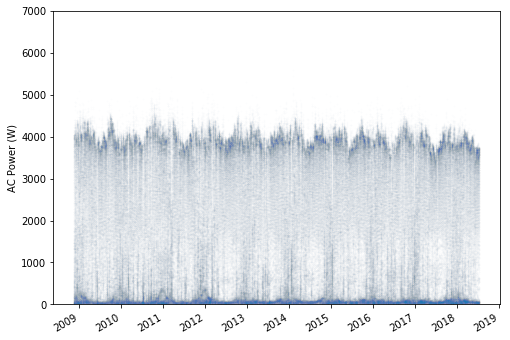

In [19]:
'''
绘制发电实际功率随时间的曲线
'''
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(df.index, df.power, 'o', alpha = 0.01)
ax.set_ylim(0,7000)
fig.autofmt_xdate()
ax.set_ylabel('AC Power (W)');

In [20]:
'''
获取整体的描述统计信息
'''
df.describe()

,12 BP Solar - Active Energy Delivered-Received (kWh),12 BP Solar - Current Phase Average (A),power,12 BP Solar - Performance Ratio (%),wind,Tamb,12 BP Solar - Weather Relative Humidity (%),ghi,dhi,12 BP Solar - Wind Direction (Degrees),12 BP Solar - Weather Daily Rainfall (mm),energy,dni,poa,Tcell
count,490665.000000,490665.000000,490665.000000,158157.000000,395605.000000,487205.000000,487205.000000,487205.000000,487205.000000,485816.000000,44958.000000,490665.000000,487205.000000,487205.000000,3.956050e+05
mean,44267.942633,8.930612,2137.520919,90.122803,3.391697,25.848454,30.598521,528.171257,113.362294,152.912873,4.381903,178.126743,635.316829,560.759378,2.725165e+51
std,25339.102053,5.447083,1412.366353,759.818177,5.503178,8.346369,20.704047,343.105710,105.107626,219.823415,8.190815,117.697196,760.965454,359.747941,1.714051e+54
min,516.000000,0.084000,-6.600000,-5.810571,-1742.130707,-39.987625,0.012130,-985.690002,1.481579,-13178.406250,0.200000,-0.550000,-144771.894087,2.540713,-3.967988e+01
25%,22088.000000,3.152666,716.599941,59.842575,2.330943,19.872990,14.780056,217.875443,50.301239,100.878916,0.400000,59.716662,178.729849,221.491579,2.953157e+01
50%,44287.000000,9.443666,2301.666737,72.413300,3.289448,26.373951,24.746498,526.366638,75.715569,134.271355,1.000000,191.805561,828.798444,573.120094,3.952134e+01
75%,66406.000000,14.190002,3490.367413,76.753021,4.273870,32.468914,39.796726,801.426636,131.139114,220.656509,4.400000,290.863951,959.049142,890.140938,4.956160e+01
max,88231.000000,22.738333,5584.966660,28701.730469,54.389500,51.261726,102.896820,2725.605957,2134.985107,10228.981445,66.800003,465.413888,391628.147318,6389.688900,1.078089e+57


In [21]:
'''
根据行的指标获得每一行时间的发电数据
'''
df.iloc[0]

12 BP Solar - Active Energy Delivered-Received (kWh)    516.000000
12 BP Solar - Current Phase Average (A)                   0.806000
power                                                    18.866662
12 BP Solar - Performance Ratio (%)                            NaN
wind                                                           NaN
Tamb                                                           NaN
12 BP Solar - Weather Relative Humidity (%)                    NaN
ghi                                                            NaN
dhi                                                            NaN
12 BP Solar - Wind Direction (Degrees)                         NaN
12 BP Solar - Weather Daily Rainfall (mm)                      NaN
energy                                                    1.572222
dni                                                            NaN
poa                                                            NaN
Tcell                                                         

In [22]:
'''
df的索引是时间序列
索引iloc[0]和loc['2008-11-11 06:00:00+09:30']是等价的
'''
df.loc['2008-11-11 06:00:00+09:30']

12 BP Solar - Active Energy Delivered-Received (kWh)    516.000000
12 BP Solar - Current Phase Average (A)                   0.806000
power                                                    18.866662
12 BP Solar - Performance Ratio (%)                            NaN
wind                                                           NaN
Tamb                                                           NaN
12 BP Solar - Weather Relative Humidity (%)                    NaN
ghi                                                            NaN
dhi                                                            NaN
12 BP Solar - Wind Direction (Degrees)                         NaN
12 BP Solar - Weather Daily Rainfall (mm)                      NaN
energy                                                    1.572222
dni                                                            NaN
poa                                                            NaN
Tcell                                                         

In [23]:
'''
筛选出发电功率大于5500kw的发电数据
'''
maxpower=df.power.loc[:]>5500

In [24]:
#找到最大发电量的发电时间为2014年2月5日12:55
df.loc[maxpower].index[0]

Timestamp('2014-02-05 12:55:00+0930', tz='Australia/North', freq='5T')

In [25]:
#从08年到18年，10年内每w组件的从早到晚的平均实际发电功率为0.42w
df.power.mean()/5100

0.41912174876785746

In [26]:
#通过查询两个维度可以分析其中的相关程度,通过dropna方式去除数据中的Nan数据
df1=df[['power','wind']].dropna(subset=['wind'])['2008-11-14 06:00:00+09:30':'2008-11-14 18:05:00+09:30']

In [27]:
df1.describe()

,power,wind
count,145.000000,145.000000
mean,2317.617760,4.530158
std,1442.574914,1.170182
min,18.333327,1.362989
25%,857.400119,3.776083
50%,2755.499840,4.591441
75%,3662.867069,5.269254
max,4004.333496,7.621149


Text(0.5,0,'wind speed')

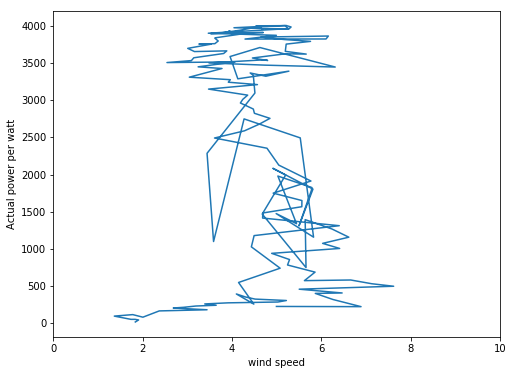

In [28]:
'''
绘制发电功率与风速之间的关系曲线
因为发电功率并不是仅仅受到风速的影响，另外从结果看来，这个结果风速对发电功率的影响效果并不明显
'''
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(df1['wind'], df1['power'])
ax.set_xlim(0,10)
#fig.autofmt_xdate()
ax.set_ylabel('Actual power per watt')
ax.set_xlabel('wind speed')

In [29]:
#按照发电量由大到小进行排序
powerlist=df.power.sort_values(ascending=False)[:1000]

In [30]:
a=powerlist.index.to_series().apply(lambda x: datetime.datetime.strftime(x, '%b %Y'))
a

Timestamp
2014-02-05 12:55:00+09:30    Feb 2014
2014-02-05 13:00:00+09:30    Feb 2014
2011-03-06 13:15:00+09:30    Mar 2011
2012-12-18 11:35:00+09:30    Dec 2012
2016-10-22 12:40:00+09:30    Oct 2016
2014-02-05 13:25:00+09:30    Feb 2014
2010-10-30 12:25:00+09:30    Oct 2010
2011-11-23 13:30:00+09:30    Nov 2011
2010-11-27 11:15:00+09:30    Nov 2010
2008-12-29 13:10:00+09:30    Dec 2008
2010-09-21 12:30:00+09:30    Sep 2010
2011-03-06 13:20:00+09:30    Mar 2011
2011-12-16 13:05:00+09:30    Dec 2011
2014-02-05 11:40:00+09:30    Feb 2014
2010-11-27 11:20:00+09:30    Nov 2010
2014-11-15 13:20:00+09:30    Nov 2014
2012-01-27 12:30:00+09:30    Jan 2012
2014-02-05 13:20:00+09:30    Feb 2014
2012-02-29 11:45:00+09:30    Feb 2012
2013-02-11 14:15:00+09:30    Feb 2013
2014-02-05 12:50:00+09:30    Feb 2014
2015-02-26 12:35:00+09:30    Feb 2015
2014-12-26 13:40:00+09:30    Dec 2014
2017-02-03 12:30:00+09:30    Feb 2017
2010-11-27 11:35:00+09:30    Nov 2010
2012-01-13 13:05:00+09:30    Jan 2012
20

In [31]:
month=[]
for each in a:
    month.append(each[:3])

In [32]:
month

['Feb',
 'Feb',
 'Mar',
 'Dec',
 'Oct',
 'Feb',
 'Oct',
 'Nov',
 'Nov',
 'Dec',
 'Sep',
 'Mar',
 'Dec',
 'Feb',
 'Nov',
 'Nov',
 'Jan',
 'Feb',
 'Feb',
 'Feb',
 'Feb',
 'Feb',
 'Dec',
 'Feb',
 'Nov',
 'Jan',
 'Jul',
 'May',
 'Feb',
 'Feb',
 'Mar',
 'Jan',
 'Aug',
 'Dec',
 'Sep',
 'Sep',
 'Nov',
 'Mar',
 'Feb',
 'Sep',
 'Oct',
 'May',
 'Feb',
 'Jan',
 'Nov',
 'Sep',
 'Feb',
 'Jul',
 'Oct',
 'Dec',
 'Oct',
 'Feb',
 'Apr',
 'Sep',
 'Feb',
 'Mar',
 'Mar',
 'Apr',
 'Sep',
 'May',
 'Nov',
 'Sep',
 'Feb',
 'Sep',
 'Mar',
 'Sep',
 'May',
 'Mar',
 'Nov',
 'Dec',
 'Nov',
 'Nov',
 'Sep',
 'Dec',
 'Sep',
 'Sep',
 'Mar',
 'Sep',
 'Nov',
 'Mar',
 'Dec',
 'Nov',
 'Dec',
 'Sep',
 'Sep',
 'Dec',
 'Dec',
 'Nov',
 'Sep',
 'Sep',
 'Feb',
 'Aug',
 'Sep',
 'Sep',
 'Jan',
 'Jan',
 'Jan',
 'Sep',
 'Feb',
 'Apr',
 'Aug',
 'Feb',
 'Mar',
 'Mar',
 'Dec',
 'Nov',
 'Nov',
 'Feb',
 'Jul',
 'Sep',
 'Mar',
 'Dec',
 'Feb',
 'Jan',
 'Feb',
 'Mar',
 'Sep',
 'Oct',
 'Oct',
 'Feb',
 'Nov',
 'Oct',
 'Mar',
 'Apr',
 'Feb',


In [33]:
num={}
for each in month:
    num[each]=month.count(each)
print(num)
type(num)

{'Feb': 134, 'Mar': 118, 'Dec': 90, 'Oct': 145, 'Nov': 87, 'Sep': 170, 'Jan': 93, 'Jul': 16, 'May': 27, 'Aug': 36, 'Apr': 71, 'Jun': 13}


dict

In [34]:
season=OrderedDict(sorted(num.items(), key=lambda t: t[1],reverse=True))
season

OrderedDict([('Sep', 170),
             ('Oct', 145),
             ('Feb', 134),
             ('Mar', 118),
             ('Jan', 93),
             ('Dec', 90),
             ('Nov', 87),
             ('Apr', 71),
             ('Aug', 36),
             ('May', 27),
             ('Jul', 16),
             ('Jun', 13)])

我列出了发电功率最大的前1000个数据，并按照月份进行了处理。可以看到，9,10两个月的组件的发电效果相对较好，其次是2月和3月。<br>
只看月份的话其实意义不大，如果和澳洲的季节结合起来，我们会发现其实9,10月正好是澳洲的初春时节，而2,3月已经是夏末了。<br>
熟悉光伏的朋友应该可以理解，`所谓的发电效率并不直接等同于光照，夏天日照虽强，但是气温较高，反而对组件的发电效率有不良影响。`<br>
而春初夏末这几个时点的气温也正好在22℃左右，是组件发电的最适宜温度

# 1:数据标准化

这一步，我们通过`rdtools.normalize_with_pvwatts()`来对数据进行标准化处理<br>
pvwatts模型中的数据都已经在上面的分析中得到

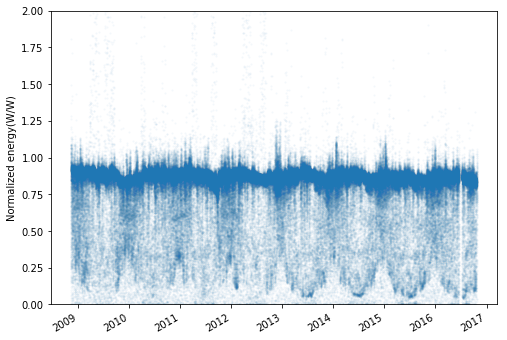

In [39]:
# 提供pvwatts模块所需要的数据
pvwatts_kws = {"poa_global" : df.poa,       #上面进行计算后的组件接受的实际辐照度
              "P_ref" : meta['pdc'],        #系统的装机容量5.1kw
              "T_cell" : df.Tcell,          #监测获得的组件温度
              "G_ref" : 1000,               #标准情况下的参考辐照度
              "T_ref": 25,                  #标准测试情况下的温度25℃
              "gamma_pdc" : meta['tempco']} #线性矩阵下的温度效能系数 1/℃

# 基于pvwatts_kws中的信息，对发电实际功率进行标准化，不同时间光伏的日射量（insolation）也可以同时获得
normalized, insolation = rdtools.normalize_with_pvwatts(df.energy, pvwatts_kws)

#每w组件实际的发电功率，上面的df.energy经修正后除以5100w
#可见大部分组件每w的发电功率都要小于1w，也有一小部分超负荷发电
df['normalized'] = normalized  
#每一个时点的日射量
df['insolation'] = insolation  

# 绘制标准化后的发电功率曲线
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(normalized.index, normalized, 'o', alpha = 0.05)
ax.set_ylim(0,2)
fig.autofmt_xdate()
ax.set_ylabel('Normalized energy(W/W)');

# 2: 数据过滤

这一步将过滤掉那些明显不合理的，产生偏差的或者引发巨大“噪声”的数据点
同时，rdtools模块也有助于过滤掉那些虽然已经中断，但是还是有低信号输出的数据点，但这种数据需要自行分析。

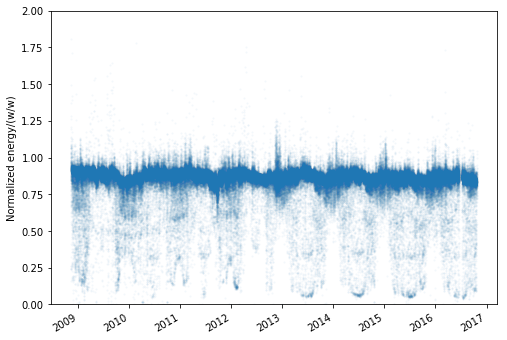

In [36]:
# 针对每一个维度的参数进行过滤
nz_mask = (df['normalized'] > 0)                #筛选出发电功率大于0的数据点
poa_mask = rdtools.poa_filter(df['poa'])        #筛选出组件辐射量在200~1200w/m2之间的数据
tcell_mask = rdtools.tcell_filter(df['Tcell'])  #筛选出组件温度在50~100℃之间的数据
clip_mask = rdtools.clip_filter(df['power'])    #过滤掉发电功率过低的点和过高的点

# 上述筛选过后，取以上筛选数据的交集，并提出其中的日射量（insolation）和发电功率（normalized）
filtered = df[nz_mask & poa_mask & tcell_mask & clip_mask]  
filtered = filtered[['insolation', 'normalized']]

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(filtered.index, filtered.normalized, 'o', alpha = 0.05)
ax.set_ylim(0,2)
fig.autofmt_xdate()
ax.set_ylabel('Normalized energy/(w/w)');

# 3: 数据聚合

数据点按照辐照度情况进行每日的加权平均计算，降低了由于日出和日落时高误差数据对数据集整体的影响

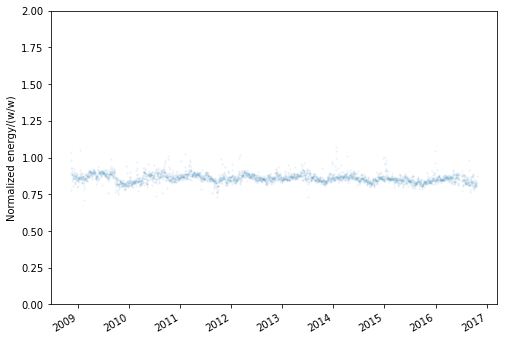

In [37]:
#对每日的发电量按照日射量进行加权平均后聚合
daily = rdtools.aggregation_insol(filtered.normalized, filtered.insolation, frequency = 'D')

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(daily.index, daily, 'o', alpha = 0.1)
ax.set_ylim(0,2)
fig.autofmt_xdate()
ax.set_ylabel('Normalized energy/(w/w)');

# 4: Pr衰减计算

分析的数据用来代表光伏系统的行为,数据可视化后可见光伏系统的pr衰减情况，这里取置信区间为0.95，进行计算

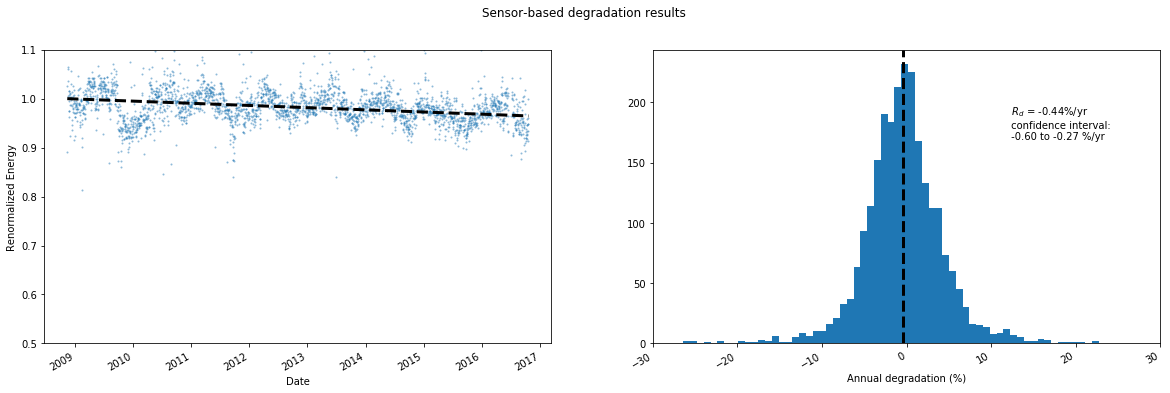

In [38]:
'''
利用rdtools中的年到年函数，基于日发电量和置信水平
计算了年到年的衰减率（Year to year degradation_rate）
置信区间（Year to year confidence_interval）
'''
yoy_rd, yoy_ci, yoy_info = rdtools.degradation_year_on_year(daily, confidence_level=95)


#对计算结果进行可视化
start = daily.index[0]
end = daily.index[-1]
years = (end - start).days / 365.0
yoy_values = yoy_info['YoY_values'] 

x = [start, end]
y = [1, 1 + (yoy_rd * years)/100]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 6))
#绘制直方图，bins代表的是划分的条段数
ax2.hist(yoy_values, label='YOY', bins=len(yoy_values)//40)
#向图中增加一条垂直线
ax2.axvline(x=yoy_rd, color='black', linestyle='dashed', linewidth=3) 
#确定x轴的坐标范围
ax2.set_xlim(-30,30)
#增加注释
ax2.annotate( u' $R_{d}$ = %.2f%%/yr \n confidence interval: \n %.2f to %.2f %%/yr' 
             %(yoy_rd, yoy_ci[0], yoy_ci[1]),  xy=(0.7, 0.7), xycoords='axes fraction',
            bbox=dict(facecolor='white', edgecolor=None, alpha = 0))
ax2.set_xlabel('Annual degradation (%)');
#数据点用o来表示
ax1.plot(daily.index, daily/yoy_info['renormalizing_factor'], 'o', alpha = 0.5)
#用一条黑色虚线回归
ax1.plot(x, y, 'k--', linewidth=3)
ax1.set_xlabel('Date')
ax1.set_ylabel('Renormalized Energy')
ax1.set_ylim(0.5, 1.1)
fig.autofmt_xdate()

fig.suptitle('Sensor-based degradation results');

一般组件安装后第一年的衰减会在2.5%左右，此后每年一般维持在0.7%。
这样看来这个光伏电站组件的Pr衰减值有95%的可能性介于0.27%-0.6%之间，显然低于一般组件的衰减。
由此可以认为此电站运用的组件质量高于市场平均水平，当然了会不会是tier one就有待考证了。

[1] General: Desert Knowledge Australia Centre. dd/mm/yyyy. Download Data. Alice Springs. http://dkasolarcentre.com.au/historical-data/download, date accessed: 17/07/2018.<br>
[2] D. Jordan, C. Deline, S. Kurtz, G. Kimball, M. Anderson, "Robust PV Degradation Methodology and Application", IEEE Journal of Photovoltaics, 2017